In [1]:
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [4]:
classes = os.listdir('../input/paddy-disease-classification/train_images')
classes

['tungro',
 'hispa',
 'downy_mildew',
 'bacterial_leaf_streak',
 'bacterial_leaf_blight',
 'brown_spot',
 'blast',
 'normal',
 'dead_heart',
 'bacterial_panicle_blight']

In [5]:
BATCH = 32
IMAGE_SIZE=(224, 224)
train_ds = idg.flow_from_directory(
    '../input/paddy-disease-classification/train_images',
    classes=classes,
    batch_size=BATCH,
    target_size=IMAGE_SIZE,
    class_mode='binary', # 0 1 2 3 4 5 6 7 8 9
    subset="training"
)
val_ds = idg.flow_from_directory(
    '../input/paddy-disease-classification/train_images',
    classes=classes,
    batch_size=BATCH,
    target_size=IMAGE_SIZE,
    class_mode='binary', # 0 1 2 3 4 5 6 7 8 9
    subset="validation"
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

80134624/80134624 [==============================] - 61s 1us/step


In [3]:
model = Sequential([
    base_model,
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
    
])

In [4]:
model.build((None, 224, 224, 3))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                        

In [11]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb=[
    EarlyStopping('val_accuracy',
                 patience=10,
                 mode='max',
                 restore_best_weights=True,
                 verbose=2),
    ModelCheckpoint('best_model.h5',
                   'val_accuracy',
                   save_best_only=True,
                   verbose=2)
]

In [13]:
model.fit(train_ds, validation_data=val_ds, epochs=64, callbacks=cb, verbose=1)

2022-08-28 12:37:51.321661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/64


2022-08-28 12:37:53.808680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 219s 799ms/step - loss: 2.0219 - accuracy: 0.2786 - val_loss: 1.9893 - val_accuracy: 0.2826

Epoch 00001: val_accuracy improved from -inf to 0.28262, saving model to best_model.h5
Epoch 2/64
261/261 [==============================] - 172s 659ms/step - loss: 1.8647 - accuracy: 0.3514 - val_loss: 1.7817 - val_accuracy: 0.3751

Epoch 00002: val_accuracy improved from 0.28262 to 0.37506, saving model to best_model.h5
Epoch 3/64
261/261 [==============================] - 173s 664ms/step - loss: 1.7525 - accuracy: 0.3824 - val_loss: 1.7145 - val_accuracy: 0.4035

Epoch 00003: val_accuracy improved from 0.37506 to 0.40347, saving model to best_model.h5
Epoch 4/64
261/261 [==============================] - 170s 653ms/step - loss: 1.6821 - accuracy: 0.4096 - val_loss: 1.6375 - val_accuracy: 0.4145

Epoch 00004: val_accuracy improved from 0.40347 to 0.41454, saving model to best_model.h5
Epoch 5/64
261/261 [==============================] - 168s 644ms/s

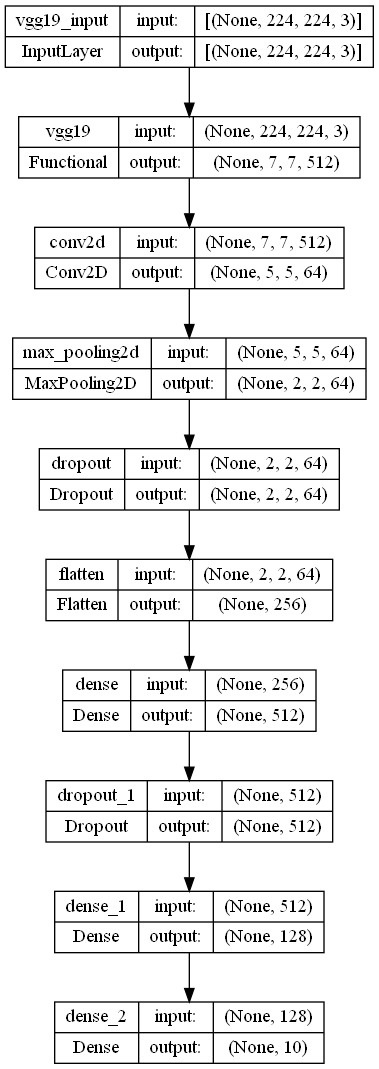

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [1]:
from keras.models import load_model
model = load_model("best_model.h5")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

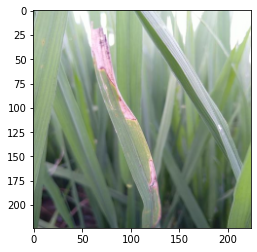

In [4]:
test_img = plt.imread('./test_image.jpg')
test_img = resize(test_img, (224, 224, 3))
plt.imshow(test_img)

In [5]:
pred = model.predict(np.array([test_img]))
pred

1/1 [==============================] - 1s 1s/step


array([[5.8348581e-02, 5.0656799e-02, 9.4827324e-02, 9.2370325e-04,
        5.3781494e-03, 2.3590375e-02, 7.3973227e-01, 2.2307122e-02,
        4.1374359e-03, 9.8244695e-05]], dtype=float32)

In [6]:
classes = ['tungro','hispa','downy_mildew','bacterial_leaf_streak','bacterial_leaf_blight','brown_spot','blast','normal','dead_heart','bacterial_panicle_blight']

for cls, prediction in zip(classes, pred[0]):
    print(f"{cls}: {prediction*100:.2f}%")

tungro: 5.83%
hispa: 5.07%
downy_mildew: 9.48%
bacterial_leaf_streak: 0.09%
bacterial_leaf_blight: 0.54%
brown_spot: 2.36%
blast: 73.97%
normal: 2.23%
dead_heart: 0.41%
bacterial_panicle_blight: 0.01%


#### test image testing

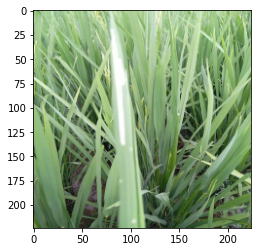

In [7]:
test_img = plt.imread('./200101.jpg')
test_img = resize(test_img, (224, 224, 3))
plt.imshow(test_img)

In [8]:
pred = model.predict(np.array([test_img]))
pred

1/1 [==============================] - 1s 532ms/step


array([[0.02138734, 0.1628063 , 0.26092625, 0.04607276, 0.06145557,
        0.3727658 , 0.03645953, 0.03004664, 0.00420037, 0.0038794 ]],
      dtype=float32)

In [9]:
classes = ['tungro','hispa','downy_mildew','bacterial_leaf_streak','bacterial_leaf_blight','brown_spot','blast','normal','dead_heart','bacterial_panicle_blight']

for cls, prediction in zip(classes, pred[0]):
    print(f"{cls}: {prediction*100:.2f}%")

tungro: 2.14%
hispa: 16.28%
downy_mildew: 26.09%
bacterial_leaf_streak: 4.61%
bacterial_leaf_blight: 6.15%
brown_spot: 37.28%
blast: 3.65%
normal: 3.00%
dead_heart: 0.42%
bacterial_panicle_blight: 0.39%


In [ ]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)
test = idg.flow_from_directory(
    directory='./train_images/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False,
    seed=42
)

In [ ]:
model.evaluate(test, batch_size = 32, verbose=1)